# Movie Genre Prediction by Naive Bayes , Logistic regresion and SVM

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer
# Models
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
#  TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

# Data Importation , Exploration and Visualisation

In [2]:
train_data = pd.read_csv('data/train_data.txt', sep=':::', names=['Title', 'Genre', 'Description'], engine='python')
train_data.head()

,Title,Genre,Description
1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
2,Cupid (1997),thriller,A brother and sister with a past incestuous r...
3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...


In [3]:
print(train_data.describe())
print(train_data.info())
print(train_data.isnull().sum())

                                 Title    Genre  \
count                            54214    54214   
unique                           54214       27   
top      Oscar et la dame rose (2009)    drama    
freq                                 1    13613   

                                              Description  
count                                               54214  
unique                                              54086  
top      Grammy - music award of the American academy ...  
freq                                                   12  
<class 'pandas.core.frame.DataFrame'>
Index: 54214 entries, 1 to 54214
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Title        54214 non-null  object
 1   Genre        54214 non-null  object
 2   Description  54214 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB
None
Title          0
Genre          0
Description    0
dtype: int64


We can see that our data tree features with 54214 entries and no null values

In [4]:
test_data = pd.read_csv('data/test_data.txt', sep=':::', names=['Id', 'Title', 'Description'], engine='python')
test_data.head()

,Id,Title,Description
0,1,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar..."
1,2,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty ch..."
2,3,Off the Beaten Track (2010),One year in the life of Albin and his family ...
3,4,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with hi..."
4,5,Er nu zhai (1955),Before he was known internationally as a mart...


In [5]:
train_data.Genre.value_counts()

Genre
drama           13613
documentary     13096
comedy           7447
short            5073
horror           2204
thriller         1591
action           1315
western          1032
reality-tv        884
family            784
adventure         775
music             731
romance           672
sci-fi            647
adult             590
crime             505
animation         498
sport             432
talk-show         391
fantasy           323
mystery           319
musical           277
biography         265
history           243
game-show         194
news              181
war               132
Name: count, dtype: int64

### Data Preprocessing

In [6]:
# Initialize the stemmer and stop words
stemmer = LancasterStemmer()
stop_words = set(stopwords.words('english'))

# Start with cleaning : clean_text function
def clean_text(text):
    text = text.lower()  # Lowercase all characters
    text = re.sub(r'@\S+', '', text)  # Remove Twitter handles
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'pic.\S+', '', text)
    text = re.sub(r"[^a-zA-Z+']", ' ', text)  # Keep only characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text + ' ')  # Keep words with length > 1 only
    text = "".join([i for i in text if i not in string.punctuation])
    words = nltk.word_tokenize(text)
    stopwords = nltk.corpus.stopwords.words('english')  # Remove stopwords
    text = " ".join([i for i in words if i not in stopwords and len(i) > 2])
    text = re.sub("\s[\s]+", " ", text).strip()  # Remove repeated/leading/trailing spaces
    return text

# Apply the clean_text function to the 'Description' column in the training and test data
train_data['Text_cleaning'] = train_data['Description'].apply(clean_text)
test_data['Text_cleaning'] = test_data['Description'].apply(clean_text)

<>:17: SyntaxWarning: invalid escape sequence '\s'
<>:17: SyntaxWarning: invalid escape sequence '\s'
C:\Users\balak\AppData\Local\Temp\ipykernel_4108\3142176950.py:17: SyntaxWarning: invalid escape sequence '\s'
  text = re.sub("\s[\s]+", " ", text).strip()  # Remove repeated/leading/trailing spaces


In [7]:
# Droping the redundant data
print(train_data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 54214 entries, 1 to 54214
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Title          54214 non-null  object
 1   Genre          54214 non-null  object
 2   Description    54214 non-null  object
 3   Text_cleaning  54214 non-null  object
dtypes: object(4)
memory usage: 2.1+ MB
None


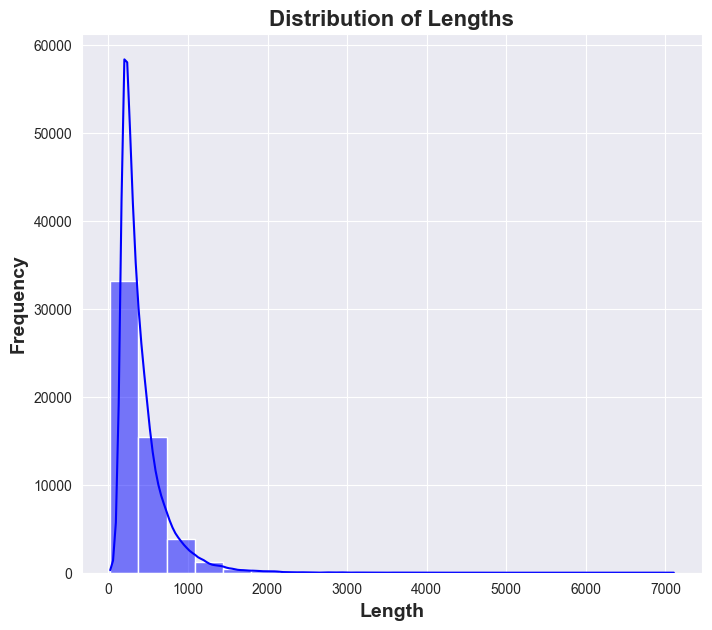

In [8]:
# Calculate the length of cleaned text
train_data['length_Text_cleaning'] = train_data['Text_cleaning'].apply(len)
# Visualize the distribution of text lengths
plt.figure(figsize=(8, 7))
sns.histplot(data=train_data, x='length_Text_cleaning', bins=20, kde=True, color='blue')
plt.xlabel('Length', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')
plt.title('Distribution of Lengths', fontsize=16, fontweight='bold')
plt.show()

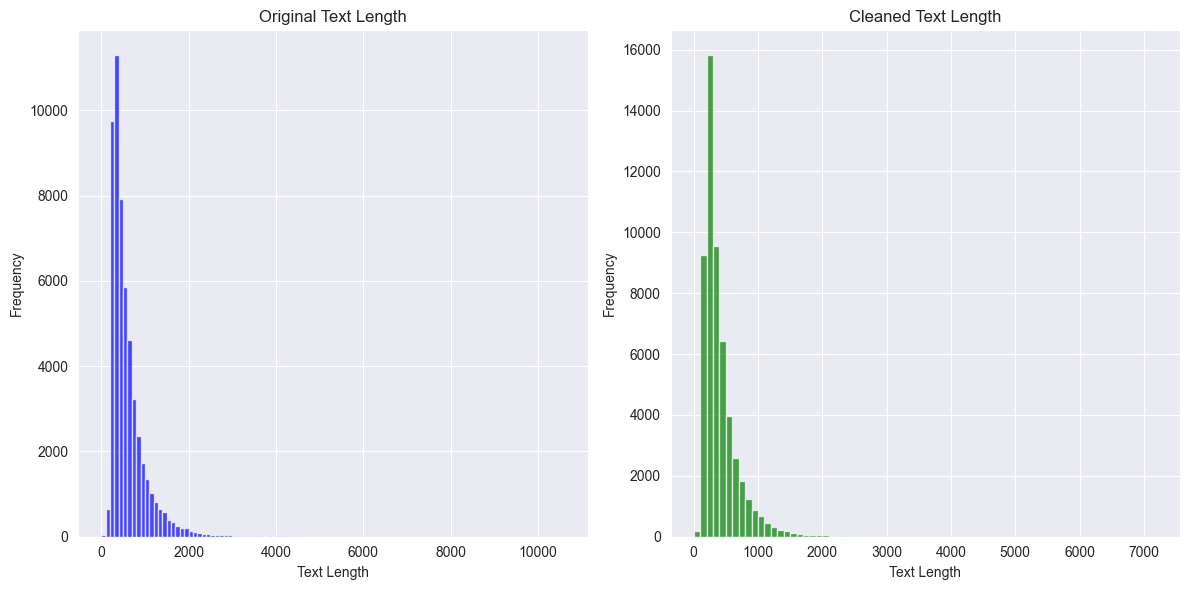

In [9]:
# Create histograms to visualize the distribution of text lengths before and after cleaning

# Set up the figure with two subplots
plt.figure(figsize=(12, 6))

# Subplot 1: Original text length distribution
plt.subplot(1, 2, 1)
original_lengths = train_data['Description'].apply(len)
plt.hist(original_lengths, bins=range(0, max(original_lengths) + 100, 100), color='blue', alpha=0.7)
plt.title('Original Text Length')
plt.xlabel('Text Length')
plt.ylabel('Frequency')

# Subplot 2: Cleaned text length distribution
plt.subplot(1, 2, 2)
cleaned_lengths = train_data['Text_cleaning'].apply(len)
plt.hist(cleaned_lengths, bins=range(0, max(cleaned_lengths) + 100, 100), color='green', alpha=0.7)
plt.title('Cleaned Text Length')
plt.xlabel('Text Length')
plt.ylabel('Frequency')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

### TF-IDF

In [10]:
train_data.head()

,Title,Genre,Description,Text_cleaning,length_Text_cleaning
1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...,listening conversation doctor parents year old...,383
2,Cupid (1997),thriller,A brother and sister with a past incestuous r...,brother sister past incestuous relationship cu...,119
3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...,bus empties students field trip museum natural...,402
4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...,help unemployed father make ends meet edith tw...,745
5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...,films title refers recovered bodies ground zer...,402


In [11]:
# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the training data
X_train = tfidf_vectorizer.fit_transform(train_data['Text_cleaning'])

# Transform the test data
X_test = tfidf_vectorizer.transform(test_data['Text_cleaning'])

# ML models
3 different models


In [12]:
X_train.shape, X_test.shape

((54214, 124210), (54200, 124210))

In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
# Split the data into training and validation sets
X = X_train
y = train_data['Genre']
X_tr, val_set, y_tr, val_label= train_test_split(X, y, test_size=0.3, shuffle=True , random_state=42)

In [14]:
# Initialize and train a Multinomial Naive Bayes classifier
classifier = {
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(),
    "Support Vector Machine": LinearSVC()
}
for model, clf in classifier.items():
    print(f"\n=========={model}===========")
    clf.fit(X_tr, y_tr)
    y_pred = clf.predict(val_set)
    print(f"\n Accuracy: {accuracy_score(val_label, y_pred)}")


==========Naive Bayes===========

 Accuracy: 0.44340608668920994

==========Logistic Regression===========


C:\Users\balak\PycharmProjectsm\MachingLearning\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



 Accuracy: 0.5743006455579465

==========Support Vector Machine===========


C:\Users\balak\PycharmProjectsm\MachingLearning\.venv\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(



 Accuracy: 0.5811865969873963
